# Exercise 1.4

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need.

**NB! The exercise is formulated in a Jupyter notebook for ease of communication, but you should feel *very* free to carry out the entire exercise without the notebook. If you do carry it out in a notebook, please finish by migrating your code over to a script that you can run from the terminal**

In [81]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [82]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [83]:
batch_size = 64
trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
images, labels = next(iter(train_loader))
print("Image size: ", np.array(images[0]).shape)
print("Image size: ", images[0].shape)

Image size:  (3, 32, 32)
Image size:  torch.Size([3, 32, 32])


* Make a CNN to train on the CIFAR10 dataset

In [85]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(
                    in_channels = 3,
                    out_channels =  8,
                    kernel_size = 3,
                    stride = 1, 
                    padding='same'),
                nn.ReLU(),
                nn.Conv2d(8, 8, 3, padding='same'),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2),
                nn.Conv2d(8, 16, 3, padding='same'),
                nn.ReLU(),
                nn.Conv2d(16, 16, 3, padding='same'),
                nn.ReLU())

        self.fully_connected = nn.Sequential(
                nn.Linear(
                    in_features = 16*16*16, 
                    out_features = 500),
                nn.ReLU(),
                nn.Linear(500, 10),
                # nn.Softmax(dim=1)
                nn.LogSoftmax(dim=1)
                )
    
    def forward(self, x):
        
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [86]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [87]:
#We define the training as a function so we can easily re-use it.
def loss_fun(output, target):
    return F.nll_loss(output, target)

    # return F.nll_loss(torch.log(output), target)
    
def train(model, optimizer, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        model.train()
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()

        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))

        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

    return out_dict

 * Train the network and plot make a plot of the loss and accuracy for both training and with the epoch on the x-axis

In [88]:
out_dict = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.056	 test: 2.237	 Accuracy train: 24.4%	 test: 29.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.666	 test: 1.569	 Accuracy train: 40.2%	 test: 43.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.340	 test: 1.359	 Accuracy train: 52.5%	 test: 52.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.143	 test: 1.686	 Accuracy train: 59.3%	 test: 43.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.961	 test: 1.409	 Accuracy train: 66.1%	 test: 52.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.764	 test: 1.342	 Accuracy train: 73.1%	 test: 56.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.559	 test: 1.439	 Accuracy train: 80.4%	 test: 58.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.383	 test: 1.747	 Accuracy train: 86.7%	 test: 56.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.278	 test: 2.036	 Accuracy train: 90.5%	 test: 56.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.191	 test: 2.564	 Accuracy train: 93.5%	 test: 54.5%


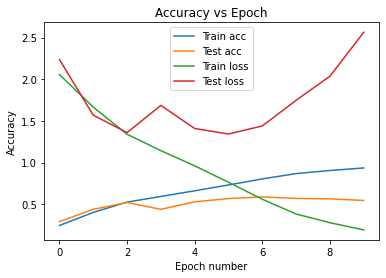

In [89]:
fig, ax = plt.subplots()
ax.plot(np.arange(10), out_dict['train_acc'], label='Train acc')
ax.plot(np.arange(10), out_dict['test_acc'], label='Test acc')
ax.plot(np.arange(10), out_dict['train_loss'], label='Train loss')
ax.plot(np.arange(10), out_dict['test_loss'], label='Test loss')
plt.title("Accuracy vs Epoch")
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?
* Which optimizer works best for you?
* Plot the test and test errors for both SGD and Adam in one plot
* Try adding Batch normalisation after your convolutional layers. Does it help?

In [90]:
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
])

In [91]:
batch_size = 64
trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transform_norm)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10('./data', train=False, download=True, transform=transform_norm)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [92]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(
                    in_channels = 3,
                    out_channels =  8,
                    kernel_size = 3,
                    stride = 1, 
                    padding='same'),
                nn.BatchNorm2d(num_features = 8),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Conv2d(8, 8, 3, padding='same'),
                nn.BatchNorm2d(num_features = 8),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.MaxPool2d(kernel_size = 2),
                nn.Conv2d(8, 16, 3, padding='same'),
                nn.BatchNorm2d(num_features = 16),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Conv2d(16, 16, 3, padding='same'),
                nn.BatchNorm2d(num_features = 16),
                nn.ReLU(),
                nn.Dropout(0.1))

        self.fully_connected = nn.Sequential(
                nn.Linear(
                    in_features = 16*16*16, 
                    out_features = 500),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(500, 10),
                nn.LogSoftmax(dim=1)
                )
    
    def forward(self, x):
        
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [93]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters())

In [94]:
out_dict1 = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.521	 test: 1.277	 Accuracy train: 44.7%	 test: 55.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.249	 test: 1.132	 Accuracy train: 55.0%	 test: 59.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.131	 test: 1.076	 Accuracy train: 59.8%	 test: 60.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.050	 test: 0.984	 Accuracy train: 62.7%	 test: 65.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.986	 test: 0.947	 Accuracy train: 65.0%	 test: 66.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.946	 test: 0.966	 Accuracy train: 66.6%	 test: 65.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.902	 test: 0.906	 Accuracy train: 68.2%	 test: 68.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.868	 test: 0.891	 Accuracy train: 69.3%	 test: 68.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.842	 test: 0.919	 Accuracy train: 70.1%	 test: 67.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.809	 test: 0.925	 Accuracy train: 71.0%	 test: 68.0%


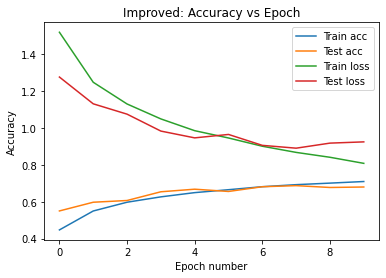

In [95]:
fig, ax = plt.subplots()
ax.plot(np.arange(10), out_dict1['train_acc'], label='Train acc')
ax.plot(np.arange(10), out_dict1['test_acc'], label='Test acc')
ax.plot(np.arange(10), out_dict1['train_loss'], label='Train loss')
ax.plot(np.arange(10), out_dict1['test_loss'], label='Test loss')
plt.title("Improved: Accuracy vs Epoch")
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

## ResNet

Now you will create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below


![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [96]:
#We define the training as a function so we can easily re-use it.
def loss_fun(output, target):
    # return F.nll_loss(torch.log(output), target)

    # cross_entropy_loss = nn.CrossEntropyLoss()
    # return cross_entropy_loss(output, target)

    return F.nll_loss(output, target)
    
def train(model, optimizer, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        model.train()
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()

        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))

        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

    return out_dict

In [97]:
batch_size = 64
trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [98]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.F = nn.Sequential(
                nn.Conv2d(
                    in_channels = n_features,
                    out_channels =  n_features,
                    kernel_size = 3,
                    stride = 1, 
                    padding='same'),
                nn.ReLU(),
                nn.Conv2d(n_features, n_features, 3, padding='same')
                )

        self.sum = nn.Sequential(
                nn.ReLU()
        )

    def forward(self, x):
        x = self.F(x) + x
        x = self.sum(x)
        return x

The following code is a sanity of your residual block network

In [99]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
# res_block = BasicBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    print(f"Desired shape: {desired_shape}, weigth shape: {weight.shape}")
    assert(desired_shape==weight.shape)
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

Desired shape: (4, 4, 3, 3), weigth shape: torch.Size([4, 4, 3, 3])
Desired shape: (4,), weigth shape: torch.Size([4])
Desired shape: (4, 4, 3, 3), weigth shape: torch.Size([4, 4, 3, 3])
Desired shape: (4,), weigth shape: torch.Size([4])
Passed sanity check


We define a network that uses your `ResNetBlock`

In [100]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

Let's train our new ResNet!

In [101]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict2 = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.890	 test: 2.121	 Accuracy train: 32.0%	 test: 25.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.507	 test: 1.617	 Accuracy train: 46.2%	 test: 43.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.265	 test: 1.421	 Accuracy train: 54.9%	 test: 51.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.073	 test: 1.215	 Accuracy train: 62.0%	 test: 56.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.864	 test: 1.311	 Accuracy train: 69.4%	 test: 55.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.605	 test: 1.447	 Accuracy train: 78.7%	 test: 56.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.357	 test: 1.701	 Accuracy train: 87.8%	 test: 56.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.206	 test: 2.469	 Accuracy train: 93.0%	 test: 54.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.146	 test: 2.524	 Accuracy train: 95.2%	 test: 55.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.096	 test: 2.722	 Accuracy train: 96.8%	 test: 55.0%


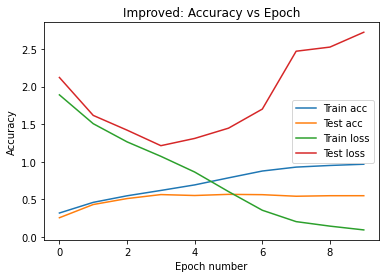

In [102]:
fig, ax = plt.subplots()
ax.plot(np.arange(10), out_dict2['train_acc'], label='Train acc')
ax.plot(np.arange(10), out_dict2['test_acc'], label='Test acc')
ax.plot(np.arange(10), out_dict2['train_loss'], label='Train loss')
ax.plot(np.arange(10), out_dict2['test_loss'], label='Test loss')
plt.title("Improved: Accuracy vs Epoch")
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()



Do you get nan loss at some point during training? 
This can be caused by the numerical instability of using softmax and log as two functions. 
* Change your network and loss to use a layer that combines the softmax log into one such as `nn.LogSoftmax`. You can also use `nn.CrossEntropyLoss` which also integrates `nn.NLLLoss`.